# AUV Localization Using Dead Reckoning Techniques with IMU Sensor

In [2]:
#Load Libraries
import numpy as np            
import pandas as pd           
import matplotlib.pyplot as plt  
import scipy                  
import filterpy

%matplotlib inline

In [3]:
# Import data from files
time_csv = pd.read_csv('.//2023-11-17-15-11-06//time.csv')

time = time_csv['time (sec)']

total_time = 79.4  # seconds
delta_t = .01  # time step in seconds
time_steps = int(total_time / delta_t)

print(time_csv)

      time (sec)
0           0.00
1           0.01
2           0.02
3           0.03
4           0.04
...          ...
7936       79.36
7937       79.37
7938       79.38
7939       79.39
7940       79.40

[7941 rows x 1 columns]


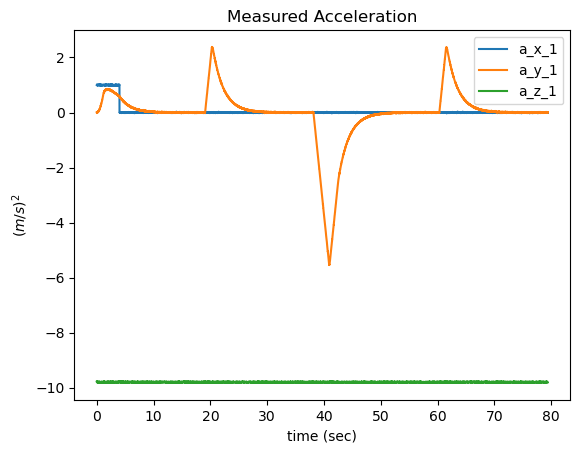

In [4]:
# Import data from files
accel_csv = pd.read_csv('.//2023-11-17-15-11-06//accel-0.csv')

a_x_1 = accel_csv['accel_x (m/s^2)']
a_y_1 = accel_csv['accel_y (m/s^2)']
a_z_1 = accel_csv['accel_z (m/s^2)']

plt.plot(time,a_x_1,label='a_x_1')
plt.plot(time,a_y_1,label='a_y_1')
plt.plot(time,a_z_1,label='a_z_1')
plt.ylabel(r'$(m/s)^2$')
plt.xlabel('time (sec)')
plt.title('Measured Acceleration')
plt.legend();

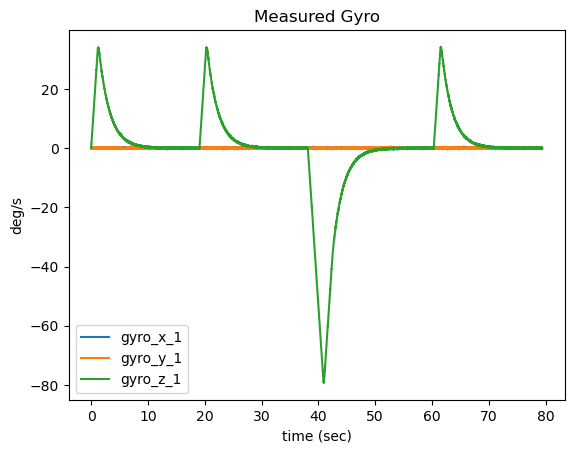

In [5]:
# Import data from files
gyro_csv = pd.read_csv('.//2023-11-17-15-11-06//gyro-0.csv')

gyro_x_1 = gyro_csv['gyro_x (deg/s)']
gyro_y_1 = gyro_csv['gyro_y (deg/s)']
gyro_z_1 = gyro_csv['gyro_z (deg/s)']

plt.plot(time,gyro_x_1,label='gyro_x_1')
plt.plot(time,gyro_y_1,label='gyro_y_1')
plt.plot(time,gyro_z_1,label='gyro_z_1')
plt.ylabel('deg/s')
plt.xlabel('time (sec)')
plt.title('Measured Gyro')
plt.legend();

In [6]:
# Import data from files
mag_csv = pd.read_csv('.//2023-11-17-15-11-06//mag-0.csv')

print(mag_csv)

      mag_x (uT)  mag_y (uT)  mag_z (uT)
0      32.396315   -3.665692   37.635251
1      32.514320   -3.574141   37.553441
2      32.503971   -3.598230   37.480783
3      32.320247   -3.524048   37.768479
4      32.451421   -3.560879   37.730508
...          ...         ...         ...
7936   32.634976   -3.638058   37.746996
7937   32.422806   -3.785732   37.735556
7938   32.736368   -3.599814   37.710934
7939   32.753251   -3.756876   37.768158
7940   32.572001   -3.695306   37.569144

[7941 rows x 3 columns]


In [7]:
# Import data from files
gps_csv = pd.read_csv('.//2023-11-17-15-11-06//ref_gps.csv')

print(gps_csv)

     ref_gps_lat (deg)  ref_gps_lon (deg)  ref_gps_alt (m)  ref_gps_vN (m/s)  \
0            32.000000         120.000000              0.0          0.000000   
1            32.000000         120.000000              0.0          0.100000   
2            32.000000         120.000000              0.0          0.199989   
3            32.000000         120.000000              0.0          0.299919   
4            32.000001         120.000000              0.0          0.399664   
..                 ...                ...              ...               ...   
790          32.000098         120.000049              0.0          4.000000   
791          32.000102         120.000049              0.0          4.000000   
792          32.000106         120.000049              0.0          4.000000   
793          32.000109         120.000049              0.0          4.000000   
794          32.000113         120.000049              0.0          4.000000   

     ref_gps_vE (m/s)  ref_gps_vD (m/s)

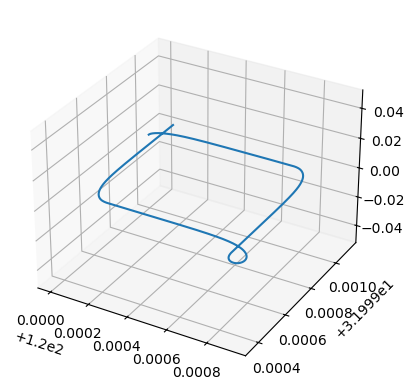

In [8]:
#Plot GPS data

lat = gps_csv['ref_gps_lat (deg)']
lon = gps_csv['ref_gps_lon (deg)']
alt = gps_csv['ref_gps_alt (m)']

gps_plot = plt.axes(projection='3d')
gps_plot.plot3D(lon,lat,alt);

# <ins> Kalman Filter Implementation </ins>

## Define Functions

In [138]:
#Calculate Orientation

def calculate_orientation(a_x, a_y, a_z, previous_pitch, previous_roll):
    
    alpha = 0.9999
    
    theta_z = np.arctan2(a_y, a_z)
    theta_x = np.arctan2(a_x, np.sqrt(a_y**2 + a_z**2))
    pitch = (previous_pitch * alpha) + (theta_x * (1 - alpha))
    roll = (previous_roll * alpha) + (theta_z * (1 - alpha))
    
    return pitch, roll

In [139]:
#Calculate Velocity

def calculate_velocity(a_x, a_y, a_z, previous_velocity_x, previous_velocity_y, previous_velocity_z, delta_t):
    
    velocity_x = previous_velocity_x + a_x * delta_t
    velocity_y = previous_velocity_y + a_y * delta_t
    velocity_z = previous_velocity_z + a_z * delta_t
    #velocity_info = np.linalg.norm(velocity_x) + np.linalg.norm(velocity_z)
    
    return velocity_x, velocity_y, velocity_z#, velocity_info

In [140]:
#Calculate Position

def calculate_position(previous_position_x, previous_position_y, velocity_x, velocity_y, delta_t):
    
    position_x = previous_position_x + velocity_x * delta_t
    position_y = previous_position_y + velocity_y * delta_t

    return position_x, position_y

In [141]:
def run_kalman_filter(data_in, dt, var):
    # Transition matrix
    F = [[1, dt, 0.5*dt**2], 
         [0,  1,       dt],
         [0,  0,        1]]
    
    # Observation matrix
    H = [0, 0, 1]
    
    # Transition covariance
    Q = [[0.2,    0,      0], 
         [  0,  0.1,      0],
         [  0,    0,  10e-4]]
    
    # Observation covariance
    R = var
    
    # Initial state mean
    X0 = [0, 0, data_in[0]]
    
    # Initial state covariance
    P0 = [[  0,    0,               0], 
          [  0,    0,               0],
          [  0,    0,   var]]
    
    n_timesteps = data_in.shape[0]
    n_dim_state = 3
    filtered_state_means = np.zeros((n_timesteps, n_dim_state))
    filtered_state_covariances = np.zeros((n_timesteps, n_dim_state, n_dim_state))
    
    kf = KalmanFilter(transition_matrices = F, 
                      observation_matrices = H, 
                      transition_covariance = Q, 
                      observation_covariance = R, 
                      initial_state_mean = X0, 
                      initial_state_covariance = P0)
    
    # Iterative estimation for each new measurement
    for t in range(n_timesteps):
        if t == 0:
            filtered_state_means[t] = X0
            filtered_state_covariances[t] = P0
        else:
            filtered_state_means[t], filtered_state_covariances[t] = (
                kf.filter_update(
                    filtered_state_means[t-1],
                    filtered_state_covariances[t-1],
                    data_in[t]
                )
            )
    return filtered_state_means[:,2]

## Load Data

In [142]:
# Load the data from the provided files
accel_data = pd.read_csv('.//2023-11-17-15-11-06//accel-0.csv')
gps_time_data = pd.read_csv('.//2023-11-17-15-11-06//gps_time.csv')
gps_visibility_data = pd.read_csv('.//2023-11-17-15-11-06//gps_visibility.csv')
gps_data = pd.read_csv('.//2023-11-17-15-11-06//gps-0.csv')
gyro_data = pd.read_csv('.//2023-11-17-15-11-06//gyro-0.csv')
mag_data = pd.read_csv('.//2023-11-17-15-11-06//mag-0.csv')
time_data = pd.read_csv('.//2023-11-17-15-11-06//time.csv')

In [143]:
# Select acceleration data
a_x_1r = accel_data['accel_x (m/s^2)'].to_numpy()
a_y_1r = accel_data['accel_y (m/s^2)'].to_numpy()
a_z_1r = accel_data['accel_z (m/s^2)'].to_numpy()

noise_level = 0.05  # Adjust as needed
a_x_1n = a_x_1r + np.random.normal(0, noise_level, a_x_1r.shape)
a_y_1n = a_y_1r + np.random.normal(0, noise_level, a_y_1r.shape)
a_z_1n = a_z_1r + np.random.normal(0, noise_level, a_z_1r.shape)

# Adding noise to create '2' data (low precision)
noise_level = 0.25  # Adjust as needed
a_x_2n = a_x_1r + np.random.normal(0, noise_level, a_x_1r.shape)
a_y_2n = a_y_1r + np.random.normal(0, noise_level, a_y_1r.shape)
a_z_2n = a_z_1r + np.random.normal(0, noise_level, a_z_1r.shape)

# GPS velocity data
gps_vN = gps_data['gps_vN (m/s)'].to_numpy()
gps_vE = gps_data['gps_vE (m/s)'].to_numpy()
gps_vD = gps_data['gps_vD (m/s)'].to_numpy()

# Time data
Time = time_data['time (sec)'].to_numpy()

## Apply Filter

In [144]:
# Apply filter to Acceleration Data
filtered_a_x_1 = run_kalman_filter(a_x_1n, dt, var=0.0007)
filtered_a_y_1 = run_kalman_filter(a_y_1n, dt, var=0.0007)
filtered_a_z_1 = run_kalman_filter(a_z_1n, dt, var=0.0007)

filtered_a_x_2 = run_kalman_filter(a_x_2n, dt, var=0.0020)
filtered_a_y_2 = run_kalman_filter(a_y_2n, dt, var=0.0020)
filtered_a_z_2 = run_kalman_filter(a_z_2n, dt, var=0.0020)

## Calculate Velocities and Positions

In [145]:
########################
# Initialize variables #
########################

previous_position_x_1, previous_position_y_1 = 0, 0
previous_position_x_2, previous_position_y_2 = 0, 0

previous_velocity_x_1, previous_velocity_y_1, previous_velocity_z_1 = 0, 0, 0
previous_velocity_x_2, previous_velocity_y_2, previous_velocity_z_2 = 0, 0, 0

previous_pitch_1, previous_roll_1 = 0, 0
previous_pitch_2, previous_roll_2 = 0, 0

velocities_x_1 = []
velocities_y_1 = []
velocities_z_1 = []

positions_x_1 = []
positions_y_1 = []

velocities_x_2 = []
velocities_y_2 = []
velocities_z_2 = []

positions_x_2 = []
positions_y_2 = []

for i in range(time_steps):

    a_x_1 = filtered_a_x_1[i]
    a_y_1 = filtered_a_y_1[i]
    a_z_1 = filtered_a_z_1[i]
    a_x_2 = filtered_a_x_2[i]
    a_y_2 = filtered_a_y_2[i]
    a_z_2 = filtered_a_z_2[i]

    ##########################
    # Calculate DR for IMU 1 #
    ##########################
     
    pitch_1, roll_1 = calculate_orientation(a_x_1, a_y_1, a_z_1, previous_pitch_1, previous_roll_1)
    velocity_x_1, velocity_y_1, velocity_z_1 = calculate_velocity(a_x_1, a_y_1, a_z_1, previous_velocity_x_1, previous_velocity_y_1, previous_velocity_z_1, delta_t)
    position_x_1, position_y_1 = calculate_position(previous_position_x_1, previous_position_y_1, velocity_x_1, velocity_y_1, delta_t)

    ##########################
    # Calculate DR for IMU 2 #
    ##########################
    
    pitch_2, roll_2 = calculate_orientation(a_x_2, a_y_2, a_z_2, previous_pitch_2, previous_roll_2)
    velocity_x_2, velocity_y_2, velocity_z_2 = calculate_velocity(a_x_2, a_y_2, a_z_2, previous_velocity_x_2, previous_velocity_y_2, previous_velocity_z_2, delta_t)
    position_x_2, position_y_2 = calculate_position(previous_position_x_2, previous_position_y_2, velocity_x_2, velocity_y_2, delta_t)
    
    ########################################
    # Update the previous values for IMU 1 #
    ########################################
    
    previous_pitch_1, previous_roll_1 = pitch_1, roll_1
    previous_velocity_x_1, previous_velocity_y_1, previous_velocity_z_1 = velocity_x_1, velocity_y_1, velocity_z_1
    previous_position_x_1, previous_position_y_1 = position_x_1, position_y_1
    
    ########################################
    # Update the previous values for IMU 2 #
    ########################################
    
    previous_pitch_2, previous_roll_2 = pitch_2, roll_2
    previous_velocity_x_2, previous_velocity_y_2, previous_velocity_z_2 = velocity_x_2, velocity_y_2, velocity_z_2
    previous_position_x_2, previous_position_y_2 = position_x_2, position_y_2
    
    velocities_x_1.append(velocity_x_1)
    velocities_y_1.append(velocity_y_1)
    velocities_z_1.append(velocity_z_1)
    
    positions_x_1.append(position_x_1)
    positions_y_1.append(position_y_1)

    velocities_x_2.append(velocity_x_2)
    velocities_y_2.append(velocity_y_2)
    velocities_z_2.append(velocity_z_2)
    
    positions_x_2.append(position_x_2)
    positions_y_2.append(position_y_2)

initial_velocity = 0
velocities_x_1 = [initial_velocity] + velocities_x_1
velocities_y_1 = [initial_velocity] + velocities_y_1
velocities_z_1 = [initial_velocity] + velocities_z_1
velocities_x_2 = [initial_velocity] + velocities_x_2
velocities_y_2 = [initial_velocity] + velocities_y_2
velocities_z_2 = [initial_velocity] + velocities_z_2

## Plot Results 

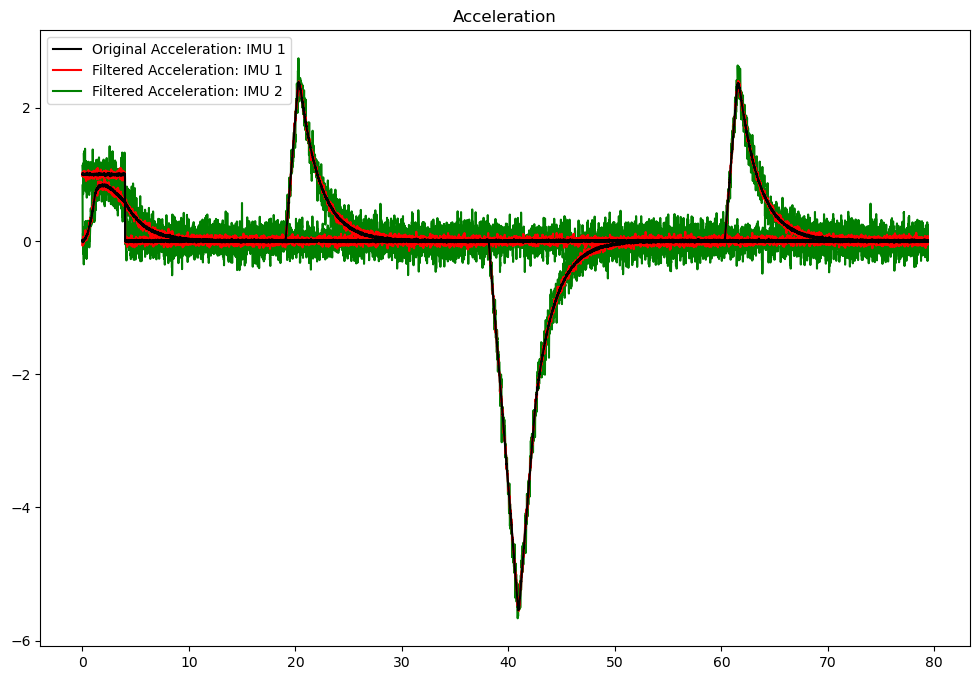

In [149]:
# Plotting acceleration
plt.figure(figsize=(12, 8))
plt.plot(time, a_x_1r, label='Original Acceleration: IMU 1',  color='black', zorder=3)
plt.plot(time, filtered_a_x_1, label='Filtered Acceleration: IMU 1',  color='red', zorder=2)
plt.plot(time, filtered_a_x_2, label='Filtered Acceleration: IMU 2',  color='green', zorder=1)
plt.plot(time, a_y_1r, alpha=1, color='black', zorder=3)
plt.plot(time, filtered_a_y_1,  color='red', zorder=2)
plt.plot(time, filtered_a_y_2, color='green', zorder=1)
#plt.plot(time, a_z_1r, label='Original Acceleration Z IMU 1', alpha=0.7)
#plt.plot(time, filtered_a_z_1, label='Filtered Acceleration Z IMU 1')
#plt.plot(time, filtered_a_z_2, label='Filtered Acceleration Z IMU 2')
plt.title('Acceleration')
plt.legend()

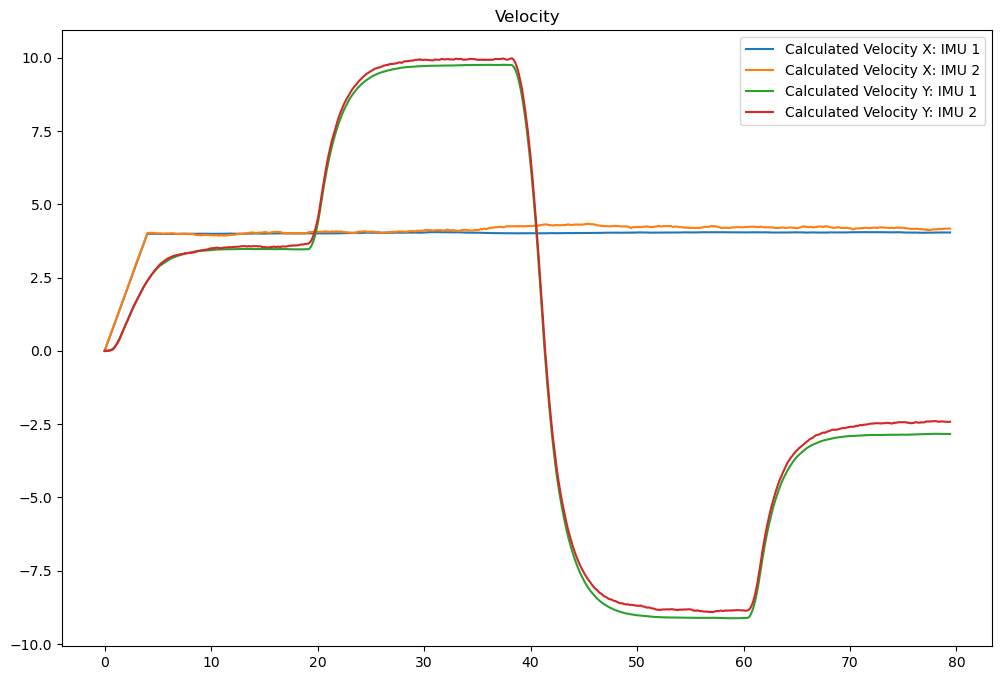

In [150]:
# Plotting velocity

plt.figure(figsize=(12, 8))
plt.plot(time, velocities_x_1, label='Calculated Velocity X: IMU 1')
plt.plot(time, velocities_x_2, label='Calculated Velocity X: IMU 2')
plt.plot(time, velocities_y_1, label='Calculated Velocity Y: IMU 1')
plt.plot(time, velocities_y_2, label='Calculated Velocity Y: IMU 2')
#plt.plot(time, velocities_z_1, label='Calculated Velocity Z IMU 1')
#plt.plot(time, velocities_z_2, label='Calculated Velocity Z IMU 2')
plt.title('Velocity')
plt.legend()
plt.show()

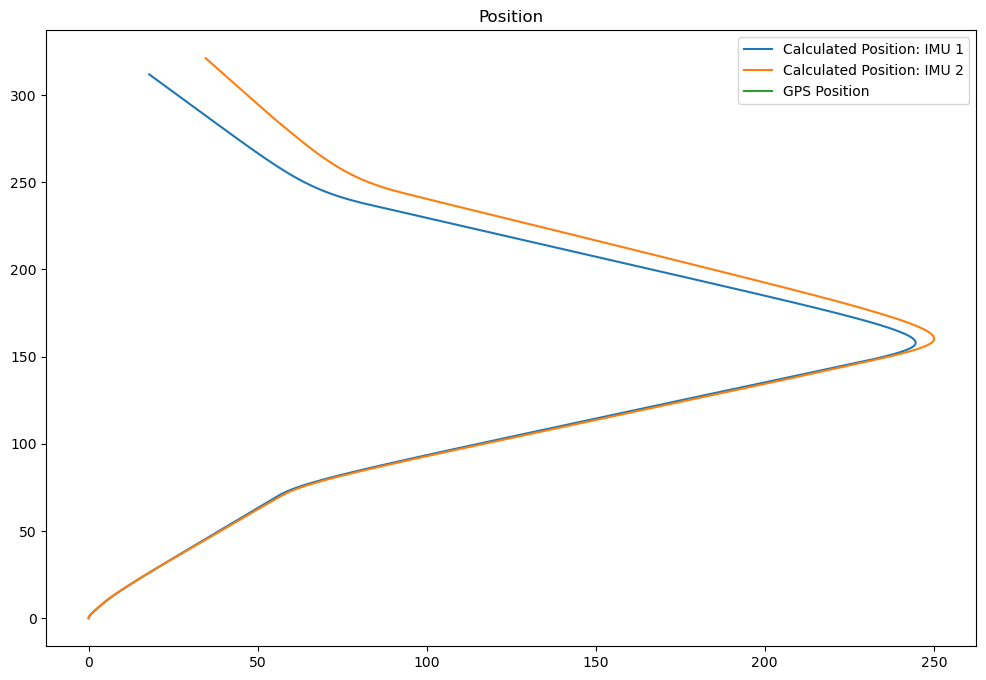

In [151]:
# Plotting GPS data

lat = gps_csv['ref_gps_lat (deg)']
lon = gps_csv['ref_gps_lon (deg)']
alt = gps_csv['ref_gps_alt (m)']

plt.figure(figsize=(12, 8))
plt.plot(positions_y_1, positions_x_1, label='Calculated Position: IMU 1')
plt.plot(positions_y_2, positions_x_2, label='Calculated Position: IMU 2')
plt.plot(lat, lon, label='GPS Position')
plt.title('Position')
plt.legend()
plt.show()